In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import urllib
import json
import os
import contextily as ctx
import numpy as np
# import tensorflow as tf

from adjustText import adjust_text
from shapely.geometry import Polygon

In [2]:
from tensorflow.signal import rfft

# Getting Data

## Hydrological Data

The list of stations used by the Federal Office of the environment can be found on this page: https://www.bafu.admin.ch/bafu/de/home/themen/wasser/daten-karten/wasser--messnetze/basismessnetz--wasserstand-und-abfluss-an-oberflaechengewaessern.html#46775952

In [33]:
station_list = pd.read_excel("data/hydrology/Stationsliste_HydrowebSAM_DE_Juli2023.xlsx", skiprows=4)

# Restrict list to stations which are active, are part of the aare system and where discharge is measured
aare_stations = station_list[
    (station_list["Betriebsstatus"] == "in Betrieb") & 
    (station_list["Flussgebiet"] == "Aaregebiet") & 
    (station_list["Messparameter"]  == "Abfluss")
]

# convert to geopandas for ease of plot
aare_stations = gpd.GeoDataFrame(
    aare_stations,
    geometry=gpd.points_from_xy(x=aare_stations["X-Koordinate"], y=aare_stations["Y-Koordinate"]),
    crs='EPSG:2056'
)

aare_stations.head()

,Betriebsstatus,Flussgebiet,Stationsnr.,Gewässer,Stationsname,Gewässertyp,X-Koordinate,Y-Koordinate,Stationshöhe [m ü.M.],Einzugsgebietsfläche [km2],Mittlere Einzugsgebietshöhe [m ü.M.],Vergletscherungsanteil [%],Messparameter,Daten verfügbar ab,Daten verfügbar bis,geometry
2,in Betrieb,Aaregebiet,70,Emme,Emmenmatt,Fliessgewässer,2623616,1200426.0,641,443.0,1065.0,0.0,Abfluss,1909-01-01,heute,POINT (2623616 1200426)
4,in Betrieb,Aaregebiet,155,Emme,"Wiler, Limpachmündung",Fliessgewässer,2608228,1223238.0,459,937.0,858.0,0.0,Abfluss,1921-07-01,heute,POINT (2608228 1223238)
27,in Betrieb,Aaregebiet,488,Simme,Latterbach,Fliessgewässer,2610681,1167849.0,666,563.0,1594.0,1.5,Abfluss,1985-05-01,heute,POINT (2610681 1167849)
60,in Betrieb,Aaregebiet,2016,Aare,Brugg,Fliessgewässer,2656959,1259353.0,336,11681.0,1000.0,1.5,Abfluss,1916-01-01,heute,POINT (2656959 1259353)
70,in Betrieb,Aaregebiet,2019,Aare,Brienzwiler,Fliessgewässer,2649942,1177374.0,574,555.0,2135.0,15.5,Abfluss,1905-01-01,heute,POINT (2649942 1177374)


Choice (up for debate): Aare-Hagneck as target which has `Stationsnr. = 2085`

In [35]:
def get_catchment_geometry(station_no: str) -> gpd.GeoDataFrame | int:
    try:
        with urllib.request.urlopen(f"https://api3.geo.admin.ch/rest/services/api/MapServer/ch.bafu.hydrologie-hydromessstationen/{station_no}") as url:
            data = json.load(url)
            geometry = data.get('feature').get('geometry')
        # somewhat strong assumption: it seems, the geometry for all stations is defined as a ring - convert to shapely.Polygon
        catchment_geom = Polygon(geometry['rings'][0])
        catchment_geom = gpd.GeoDataFrame([{'geometry': catchment_geom}], crs="EPSG:21781") #EPSG:21781 the LV95 coordinate projection
        return catchment_geom
    except Exception as e:
        print(f"Something went wrong: {e}")
        return 0

catchment = get_catchment_geometry("2085")

In [36]:
# change the coordinate projection to the OpenStreetMap projection
catchment = catchment.to_crs(epsg=3857)
aare_stations = aare_stations.to_crs(epsg=3857)

# create a column whether a station is in catchment = is upriver 
aare_stations["in_catchment"] = aare_stations.geometry.apply(lambda geom: catchment.geometry[0].contains(geom))

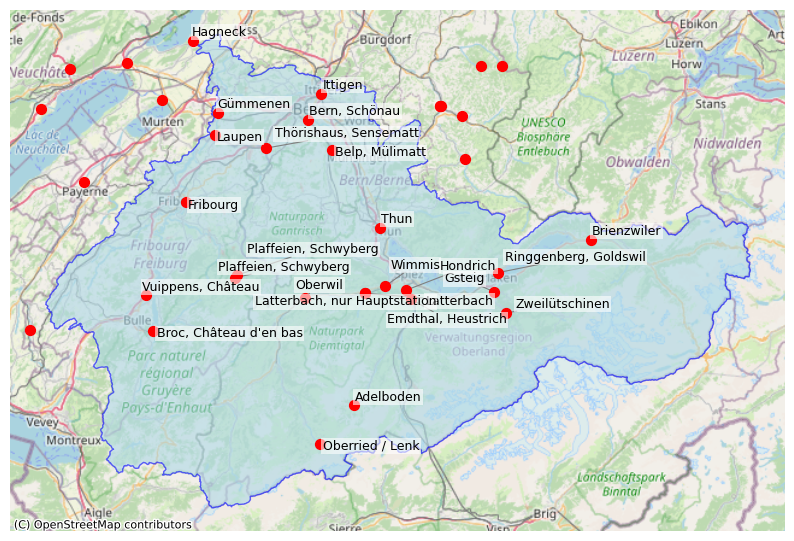

In [37]:
# Plot with map
fig, ax = plt.subplots(figsize=(10, 8))
catchment.plot(ax=ax, facecolor="lightblue", edgecolor="blue", alpha=0.6)

# Add basemap (OpenStreetMap tiles)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add hydrological stations and name those in catchment
aare_stations.plot(ax=ax, color="red", markersize=50, zorder=5)

texts = []
for idx, row in aare_stations[aare_stations["in_catchment"]==True].iterrows():
    texts.append(
        ax.text(
            row.geometry.x,
            row.geometry.y,
            row["Stationsname"],
            fontsize=9,
            color="black",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1),
            zorder=6
        )
    )

# Adjust positions to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="->", color="gray", lw=0.8))


ax.set_axis_off()
plt.show()

In [3]:
# Load data
hydro = pd.read_csv("data/hydrology/aare_2010.csv")
for year in np.arange(2011, 2025):
    tmp = pd.read_csv(f"data/hydrology/aare_{year}.csv")
    hydro = pd.concat([hydro, tmp])

# convert index to datetime
date_time = pd.to_datetime(hydro['timestamp'], format='%Y-%m-%d %H:%M:%S.000000 UTC')
hydro.set_index(date_time)

# convert to wide data frame
wide_hydro = hydro.pivot(index="timestamp", columns="station_no", values="value")
wide_hydro.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
station_no,,,,,,,,
2019,788976.0,36.893135,25.401705,2.213,16.802,30.3090,52.54100,367.108
2030,788976.0,111.646131,69.643343,24.948,56.587,91.8940,154.59400,499.180
2085,788976.0,168.991260,96.377453,17.592,98.677,151.3480,213.13100,1163.731
2109,788976.0,18.848872,17.321321,1.459,5.081,12.3350,29.14500,225.255
2135,788976.0,122.280430,71.774729,30.980,66.500,102.8145,163.25400,561.400
2159,788976.0,2.742226,3.134101,0.008,1.188,1.9330,3.10400,64.049
2160,788976.0,19.977767,20.385589,1.789,6.281,10.4340,28.55600,444.608
2179,788976.0,8.195178,9.975646,1.283,3.223,5.5150,9.05600,297.040
2215,788976.0,49.067556,48.117895,3.738,11.836,22.7040,82.77425,856.441


### Seasonal cycle?

Does our target Hagneck show a clear seasonal cycle? To answer, let's perform a quick fourier transformation

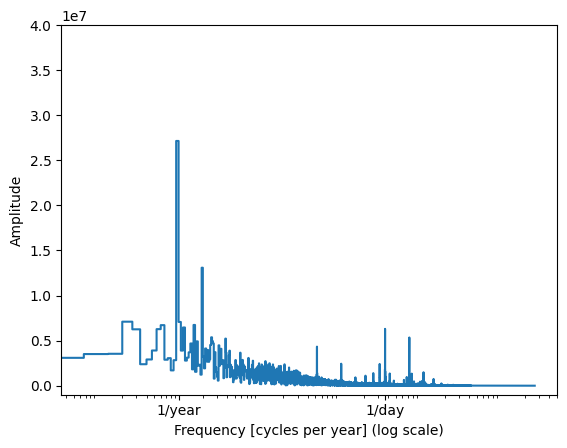

In [4]:

# Your series for station 2085
x = wide_hydro[2085].values
n_samples = len(x)

# --- FFT ---
fft = rfft(x)

# --- Frequency axis ---
# Assume your data is hourly → sampling interval = 1 hour
dt = 1.0/6.0   # hours
freqs_per_hour = np.fft.rfftfreq(n_samples, d=dt)

# Convert to cycles per year (instead of per hour)
hours_per_year = 24 * 365.2524
freqs_per_year = freqs_per_hour * hours_per_year

# --- Plot ---
plt.step(freqs_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(-0.01e8, 0.4e8)
plt.xticks([1, 365.2524], labels=['1/year', '1/day'])
plt.xlabel("Frequency [cycles per year] (log scale)")
plt.ylabel("Amplitude")
plt.show()


Most pronounced cycle: ~1.00 years


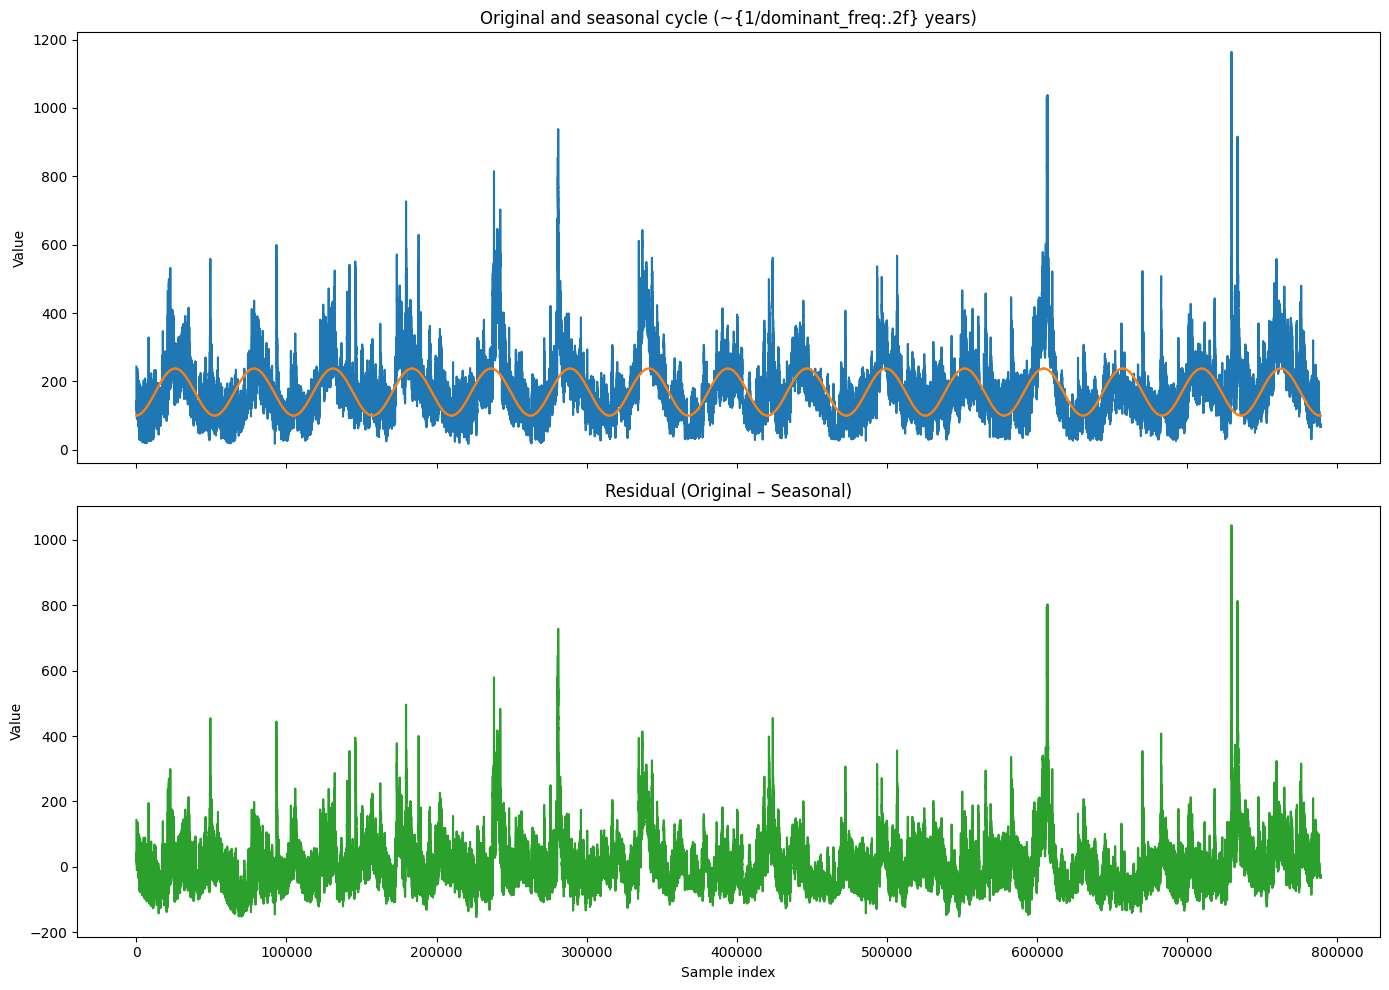

In [5]:
# --- Find dominant frequency ---
power = np.abs(fft)**2
dominant_idx = np.argmax(power[1:]) + 1
dominant_freq = freqs_per_year[dominant_idx]
print(f"Most pronounced cycle: ~{1/dominant_freq:.2f} years")

# --- Reconstruct seasonal component ---
fft_yearly = np.zeros_like(fft, dtype=complex)
fft_yearly[0] = fft[0]                         # keep mean
fft_yearly[dominant_idx] = fft[dominant_idx]   # keep strongest seasonal
seasonal = np.fft.irfft(fft_yearly, n=n_samples)

# --- Residual ---
residual = x - seasonal

# --- Subplots ---
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

axes[0].plot(x, color="C0")
axes[0].set_title("Original and seasonal cycle (~{1/dominant_freq:.2f} years)")
axes[0].plot(seasonal, color="C1")
axes[0].plot(seasonal, color="C1")

axes[1].plot(residual, color="C2")
axes[1].set_title("Residual (Original – Seasonal)")

for ax in axes:
    ax.set_ylabel("Value")
axes[-1].set_xlabel("Sample index")

plt.tight_layout()
plt.show()


In [12]:
# ensure DatetimeIndex
wide_hydro.index = pd.to_datetime(wide_hydro.index)
idx = wide_hydro.index  # DatetimeIndex

# day-of-year (1..366), seconds within the day, and days-in-year per timestamp
day_of_year = idx.dayofyear
seconds_of_day = idx.hour * 3600 + idx.minute * 60 + idx.second + idx.microsecond / 1e6
days_in_year = np.where(idx.is_leap_year, 366, 365)

# fractional position in that specific calendar year (0..1)
frac_of_year = ((day_of_year - 1) + seconds_of_day / 86400.0) / days_in_year

wide_hydro['year_sin'] = np.sin(2 * np.pi * frac_of_year)
wide_hydro['year_cos'] = np.cos(2 * np.pi * frac_of_year)


In [41]:
train_hydro = wide_hydro[wide_hydro.index<'2024-01-01']
test_hydro = wide_hydro[wide_hydro.index>='2024-01-01']

y_train = train_hydro.pop(2085)
y_test = test_hydro.pop(2085)

train_hydro.columns = train_hydro.columns.astype(str)

Index(['2019', '2030', '2109', '2135', '2159', '2160', '2179', '2215', '2232',
       '2457', '2467', '2500', 'Year sin', 'Year cos', 'year_sin', 'year_cos'],
      dtype='object', name='station_no')

In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),
        ('std_scaler', StandardScaler()),
    ])

num_attributes = housing_num = train_hydro.select_dtypes(include=[np.number])
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attributes),
    ])

hydro_train_prepared = full_pipeline.fit_transform(train_hydro)
hydro_train_prepared.head()

ValueError: No valid specification of the columns. Only a scalar, list or slice of all integers or all strings, or boolean mask is allowed

<Axes: xlabel='timestamp'>

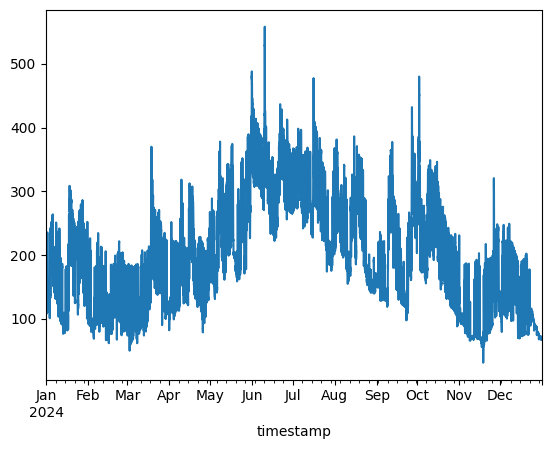

In [30]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

### Simple linear regression - no time awareness

In [ ]:
from sklearn.linear_model import LinearRegression



## Meteorological stations

In [49]:
meteo_stations = pd.read_csv("https://data.geo.admin.ch/ch.meteoschweiz.ogd-smn-precip/ogd-smn-precip_meta_stations.csv", sep=';', encoding='latin-1')

meteo_stations = gpd.GeoDataFrame(
    meteo_stations,
    geometry=gpd.points_from_xy(x=meteo_stations.station_coordinates_lv95_east, y=meteo_stations.station_coordinates_lv95_north),
    crs='EPSG:2056'
)

meteo_stations = meteo_stations.to_crs(epsg=3857)

meteo_stations["in_catchment"] = meteo_stations.geometry.apply(lambda geom: catchment.geometry[0].contains(geom))

meteo_stations[meteo_stations['in_catchment']==True]

,station_abbr,station_name,station_canton,station_wigos_id,station_type_de,station_type_fr,station_type_it,station_type_en,station_dataowner,station_data_since,...,station_exposition_de,station_exposition_fr,station_exposition_it,station_exposition_en,station_url_de,station_url_fr,station_url_it,station_url_en,geometry,in_catchment
13,BEP,Belp,BE,0-756-0-BEP,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,MeteoSchweiz,01.01.1901,...,Ebene,Plaine,Pianura,plain,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (835490.081 5926760.134),True
36,GAD,Gadmen,BE,0-756-0-GAD,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,"Kt. BE, SLF",28.07.1911,...,Tal,Vallée,Valle,valley,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (929644.886 5899228.06),True
39,GTT,Guttannen,BE,0-756-0-GTT,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,MeteoSchweiz,01.08.1876,...,Tal,Vallée,Valle,valley,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (923030.308 5886177.71),True
45,KAS,Kandersteg,BE,0-756-0-KAS,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,MeteoSchweiz,01.08.1899,...,Tal,Vallée,Valle,valley,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (854618.782 5859844.991),True
46,KIE,Kiental,BE,0-756-0-KIE,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,Kt. BE,01.01.1901,...,Tal,Vallée,Valle,valley,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (860176.756 5874205.088),True
47,KIS,Kiesen,BE,0-756-0-KIS,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,MeteoSchweiz,01.01.1972,...,Ebene,Plaine,Pianura,plain,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (843026.148 5912875.622),True
57,LTB,Lauterbrunnen,BE,0-756-0-LTB,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,MeteoSchweiz,01.08.1899,...,Osthang,Versant est,Versante orientale,eastern oriented slope,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (880143.514 5875880.573),True
139,ZWE,Zweisimmen,BE,0-756-0-ZWE,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,Kt. BE,01.01.1901,...,Tal,Vallée,Valle,valley,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.

In [62]:
# Downloading precipitation data now
download_url = [
    (f"https://data.geo.admin.ch/ch.meteoschweiz.ogd-smn-precip/{abr.lower()}/ogd-smn-precip_{abr.lower()}_t_historical_2010-2019.csv", abr) for abr in meteo_stations[meteo_stations["in_catchment"]]["station_abbr"]
]

path = os.path.join(os.path.curdir, 'data', 'meteorology')
for url, abr in download_url:
    try:
        df = pd.read_csv(url, sep=";")
        df.to_csv(os.path.join(path, f"{abr}.csv"))

    except Exception as e:
        print(f"An Issue with {abr} ({url}): {e}")
        continue

An Issue with GAD (https://data.geo.admin.ch/ch.meteoschweiz.ogd-smn-precip/gad/ogd-smn-precip_gad_t_historical_2010-2019.csv): HTTP Error 403: Forbidden
